# GANによる画像生成

commit用

```mycode/5_gan_generation/```

In [29]:
!gpustat

s2                   Wed Apr 15 16:54:47 2020  440.44
[0] Quadro RTX 8000  | 38'C,   0 % | 34413 / 48601 MB | inoue(34401M)
[1] Quadro RTX 8000  | 25'C,   0 % |     0 / 48601 MB |
[2] Quadro RTX 8000  | 29'C,   0 % |  2675 / 48601 MB | hasegawa(2663M)
[3] Quadro RTX 8000  | 25'C,   0 % |     0 / 48601 MB |
[4] Quadro RTX 8000  | 63'C,  91 % |  8859 / 48601 MB | hara(8847M)
[5] Quadro RTX 8000  | 66'C,  99 % | 10797 / 48601 MB | taoli(10783M)
[6] Quadro RTX 8000  | 65'C, 100 % | 16864 / 48601 MB | taoli(10587M) taoli(6259M)
[7] Quadro RTX 8000  | 66'C, 100 % |  6263 / 48601 MB | taoli(6249M)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [19]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms


# 実装したネットワークで出力
import matplotlib.pyplot as plt
%matplotlib inline

## 5-3 Self-Attention GANの概要

2018年時点で最高峰のGANの１つである**BigGAN**もSAGANをベースとしているGANである．本節では

- Self-Attention
- pointwise convolution
- Spectral Normalization

の３つのテーマについての理解を目標とする．

### 従来のGANの問題点
従来のGANの転置畳み込みを繰り返す操作は特徴量マップが大きくなりますが，転置畳み込みの繰り返しでは**局所的な情報の拡大にしかならない**問題がある．

よってより良い画像生成を実現するためには可能であれば拡大する際に画像全体の大域的な情報を考慮する仕組みが必要になる．

### Self-Attentionの導入
従来のニューラルネットワークでは前の層の出力がそのまま次の層に入力されるので式としては
$$
y = x
$$
で表される．しかしこれでは局所的な性質が常に伝わっていくので，さらに大域的な情報を用いて表される$o$を導入する．この$o$に係数$\gamma$をかけた値を足して次の層に伝達することを考える．
$$
y = x +\gamma o
$$
この$o$をどのように求めるかについては以下の手順で求める．
1. $x$を[C,W,H]から[C,N]に変形する. $N=W\times H$
2. $S=x^Tx$ という行列を用意する．これは画像位置$i$と画像位置$j$の関係性を表す行列である．
3. $S$を行方向にソフトマックス関数にかける．これで画像位置$i$と画像位置$j$の関係性の総和が1になり扱いやすくなる．これを$\beta$とし，これを**Attention Map**という．
4. 上で作った$\beta$を$x$にかけることで$o$を得る．つまり$o = x\beta^T$である．$o=[C,N]$

この$o = x\beta^T$について
$$
o_{c=k,n=j} = \sum_{i=1}^Nx_{ki}\beta_{ji}
$$
この式はチャネル$k$において位置$j$について位置$i=1,2,\cdots N$の全ての影響を総和することを意味している．
$x_{ki}$ はチャネル$k$の位置$i$の特徴量を表していて，$\beta_{ji}$は位置$j$と位置$i$の関係性を表して，この$\sum$はそれらの積の総和を求めている．


In [4]:
#　最初のサイズ変形 (B,C,W,H)  to (B,C,N)
X = torch.randn(3,32,64,64)
X = X.view(X.shape[0], X.shape[1], -1)

# 掛け算
X_T = X.permute(0,2,1)
S = torch.bmm(X_T, X)

# 規格化
m = nn.Softmax(dim=-2)
attention_map_T = m(S)
attention_map = attention_map_T.permute(0,2,1)

# Self-Attention Map
o = torch.bmm(X, attention_map.permute(0,2,1))

### 1×1 Convolutions (pointwise convolution)
Self-Attention の制限は非常に強いのでこのままでは学習はうまくいかないことが多い．
そこでpointwise convolutionと呼ばれる前処理をした特徴量マップをSelf-Attentionに渡してあげることによって学習がうまくいくようにする．
またこれをすることによって特徴量マップのチャネル数を変えることができる(一般にはチャネル数を減らす)ので計算量を調整することができる．

またpointwise convolutionでは次の言葉が使われる
- query：元の入力$x$の転置に対応するもの
- key：元の入力$x$に対応するもの
- value：Attention Mapと掛け算する対象

出力のチャネルはカーネルの数となる．カーネルのチャネルは入力のチャネルに合わせる

In [5]:
X = torch.randn(3,32,64,64)

# 1×1の畳み込み層によるpointwise convolutionを用意　
query_conv = nn.Conv2d(
    in_channels=X.shape[1], out_channels=X.shape[1]//8, kernel_size=1)

key_conv = nn.Conv2d(
    in_channels=X.shape[1], out_channels=X.shape[1]//8, kernel_size=1)

value_conv = nn.Conv2d(
    in_channels=X.shape[1], out_channels=X.shape[1], kernel_size=1)

# 畳み込みをしてからサイズを変更する
proj_query = query_conv(X).view(
    X.shape[0], -1, X.shape[2]*X.shape[3])
proj_query = proj_query.permute(0,2,1)
proj_key = key_conv(X).view(
    X.shape[0], -1, X.shape[2]*X.shape[3])

# 掛け算
S = torch.bmm(proj_query, proj_key) # bmmはバッチごとの掛け算を行う

# 規格化
m = nn.Softmax(dim=-2)
attention_map_T = m(S)
attention_map = attention_map_T.permute(0,2,1)

# Self-Attention Map
proj_value = value_conv(X).view(
    X.shape[0], -1, X.shape[2]*X.shape[3])
o = torch.bmm(proj_value, attention_map.permute(0,2,1))

### Spectral Normalization
- Spectral Normalization：畳み込みの重みに対する規格化
- Batch Normalization：ディープラーニングモデルを流れるデータに対する規格化

***リプシッツ連続性(Lipschitz continuity)：***判別機Dの出力が入力データに対して頑健性を持つこと
具体的には層を表す行列の固有値のうち最大の固有値で全ての重みを割ることで規格化している．固有値は固有ベクトルの拡大率なので，一番拡大される固有値で全てを規格化することによって流れるデータが想定外に大きくなることを防ぐ．

In [6]:
z_dim = 20
image_size = 64
nn.utils.spectral_norm(nn.ConvTranspose2d(
    z_dim, image_size*8, kernel_size=4,stride=1))

ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))

## 5-4 Self-Attention GANの学習，生成の実装

### Self-Attentionモジュールの実装
$$
y = x + \gamma o
$$
$\gamma$ は初期値０から始めるが，学習させる対象なのでこれも```nn.Parameter()```を用いて実装する．

Attention MapはあとでAttentionの強さを可視化するために出力させてる

In [6]:
class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""
    
    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()
        
        # 1×1の畳み込み層によるpointwise convolutionを用意　
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)

        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)

        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        # 規格化
        self.softmax = nn.Softmax(dim=-2)
        
        # gamma
        # 学習させるのでnn.Parameter　を用いる
        self.gamma = nn.Parameter(torch.zeros(1))
        
        
    def forward(self, x):
        
        # 入力変数
        X = x
        
        # 畳み込みをしてからサイズを変更する
        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        proj_query = proj_query.permute(0,2,1)
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        
        
        # 掛け算
        S = torch.bmm(proj_query, proj_key) # bmmはバッチごとの掛け算を行う  
        
        # 規格化
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0,2,1)
        
        # Self-Attention Map
        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0,2,1))
        
        # Self-Attention　MapのテンソルサイズをXに揃えて出力
        o = o.view(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
        out = x + self.gamma*o
        
        return out , attention_map

### Generatorの実装
DCGANとの変更点は以下の2点である．
1. 最後のlaseのLayer以外には転置畳み込み層にSpectral Normalizationを追加する．
2. layer3-layer4と，layer4-lastの二箇所にSelf-Attentionモジュールを追加する

In [7]:
class Generator(nn.Module):
    
    def __init__(self, z_dim = 20, image_size=64):
        super(Generator, self).__init__()
        
        
        self.layer1 = nn.Sequential(
            #　ここでConvTranspose2dにspectral_norm を作用させる
#             nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4,stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4,stride=2, padding=1)), #spectral_norm
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4,stride=2, padding=1)), #spectral_norm
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        # Self-Attention 層
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
              
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4,stride=2, padding=1)), #spectral_norm
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Self-Attention 層
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 白黒なので出力は1チャネル

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

### Discriminatorの実装
DCGANからの変更点は以下の2点
1. last以外のlayerに畳み込み層にSpectral Normalizationを追加する
2. layer3-layer4と，layer4-lastの二箇所にSelf-Attentionモジュールを追加する

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)), # Spectral Normalizationの追加
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)),# Spectral Normalizationの追加
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),# Spectral Normalizationの追加
            nn.LeakyReLU(0.1, inplace=True))
        
        # Self-Attention層の追加
        self.self_attention1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),# Spectral Normalizationの追加
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention層の追加
        self.self_attention2 = Self_Attention(in_dim=image_size*8)
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

### DataLoaderの実装
DCGANと同じ

In [9]:
def make_datapath_list():
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
        img_path = "./data/img_78/img_8_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
    return train_img_list


class ImageTransform():
    """
    画像クラスの前処理
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)
    

class GAN_Img_Dataset(data.Dataset):
    """
    画像のDataset
    """
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
            
    def __len__(self):
        """画像の枚数を返す"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        """前処理をした画像のTensor形式のデータを取得"""
        
        img_path = self.file_list[index]
        img = Image.open(img_path) #H,W,C
        
        # 前処理
        img_transformed = self.transform(img)
        
        return img_transformed


In [10]:
# DataLoaderの作成
train_img_list = make_datapath_list()
# print(train_img_list)

# Datasetの作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(train_img_list, ImageTransform(mean, std))

# DataLoaderの作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size = batch_size, shuffle=True)

### ネットワークの初期化と学習の実施
SAGANの損失関数はhinge version of the adversarial lossと呼ばれるものに変更している
$$
-\frac{1}{M}\sum_{i=1}^M[l_i \ast \min (0, -1+y_i) + (1-l_i)\ast \min(0, -1-y_i)]
$$
これは実装では
```d_loss_real = torch.nn.ReLU()(1.0-d_out_real).mean()``` となる．ここでReLUは活性化関数ではなくmin(正確にはmax)の部分に相当する．

**シグモイドにはしてないがこれは？**
- これは```d_out_real```が~~正の値しかとらないのでReLU関数の出力は結果として[0,1]におさまる．~~よってシグモイドを作用させたのと同じ効果がある．

またGの方では以下のように損失関数を改める．
$$
-\frac{1}{M}\sum_{i=1}^M D(G(z_i))
$$
これによって実装は
```g_loss = - d_out_fake.mean()``` となる．

このような損失関数が用いられているのは経験的にうまくいくからである．

In [49]:
# モデルを学習させる関数の作成
def train_model(G,D,dataloader, num_epochs):
    
    # GPU環境の確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス : ", device)
    
    # 最適化手法の設定
    g_lr, d_lr = 0.00001, 0.00004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2] )
    d_optimizer = torch.optim.Adam(D.parameters(), g_lr, [beta1, beta2] )
    
    
    # 誤差関数の定義 
#     criterion = nn.BCEWithLogitsLoss(reduction="mean")
    """
    誤差関数はhinge version of the adversarial loss に変更
    """

    # パラメータ
    z_dim = 20
    mini_batch_size = 64
    
    # GPU
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    # 高速化
    torch.backends.cudnn.benchmark = True
    
    # 画像枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    
    # epochのループ
    for epoch in range(num_epochs):
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        if ((epoch+1)%20==0):
            print("-----------------------------------")
            print("Epoch {}/{} ".format(epoch, num_epochs))
            print("-----------------------------------")
            print("---  (train)  ---")
        
        # データローダからmini_batchずつ取り出す
        for imges in dataloader:

            
            """
            
            1.　Disicriminatorの学習
            
            """
            # ミニバッチがサイズが1だと，バッチノーマライゼーションでエラーになるので避ける
            if imges.size()[0] == 1:
                continue
                
            # GPUが使えるなら使う
            imges = imges.to(device)
            
            # 　正解ラベルと偽ラベルを作成
            # 最後のepochだけはミニバッチの余りなので数が少なくなる
            mini_batch_size = imges.size()[0]
#             label_real = torch.full((mini_batch_size,),1).to(device)
#             label_fake = torch.full((mini_batch_size,),0).to(device)
            
            # 真の画像を判定
            d_out_real, _, _  = D(imges)   # 出力が増えてるので変更

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1), 1,1 ) 
            fake_images,_ , _ = G(input_z) 
            d_out_fake,_ ,_  = D(fake_images)
            
            """---------------------------------------------------------------------
            この部分を誤差関数の変更に伴って大きく変更
            """
            # 誤差の計算
#             d_loss_real = criterion(d_out_real.view(-1), label_real)
#             d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
#             d_loss = d_loss_real + d_loss_fake

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 誤差関数の出力が0以上になるように調整している．
#             print("d_out_real : ", d_out_real)
#             print("d_loss_real : ",d_loss_real)
            
            d_loss_fake = torch.nn.ReLU()(1.0+d_out_fake).mean()
            # これは[0,1]からは出てしまうが，d_out_fakeの出力が0に近いほど良いというところを実装している
            
            d_loss = d_loss_real + d_loss_fake
            

            """---------------------------------------------------------------------"""
            
            # backward()
            g_optimizer.zero_grad()  # ここでどちらも初期化すること！
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
        
            """
            
            2.　Generatorの学習
            
            """
            
            # 偽画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1), 1,1 )
            fake_images,_ ,_  = G(input_z)
            d_out_fake,_ ,_ = D(fake_images)
            
        
            """---------------------------------------------------------------------
            この部分を誤差関数の変更に伴って大きく変更
            """
            # 誤差の計算
#             g_loss = criterion(d_out_fake.view(-1), label_real)

            g_loss = - d_out_fake.mean()


            """---------------------------------------------------------------------"""
            
            # backward()
            g_optimizer.zero_grad()  # ここでどちらも初期化すること！
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()

            """
            
            3.　記録
            
            """
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        if ((epoch+1)%20==0):
            t_epoch_finish = time.time()
            print("----------------------------")
            print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
                epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
            print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
            t_epoch_start = time.time()
        if((epoch+1)==num_epochs):
            torch.save(G.state_dict(), "weights/sagan_g_"+str(epoch+1) + ".pth")
            torch.save(D.state_dict(), "weights/sagan_d_"+str(epoch+1) + ".pth")

    return G, D

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス : ", device)

使用デバイス :  cuda:0


In [36]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [45]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02) # mean  = 0.0 , std = 0.02
        nn.init.constant_(m.bias.data,0)
    elif classname.find("BatchNorm") != -1:
        #BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data,0)
        
G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)
        
# 初期化の実施
# G.apply(weights_init)
# D.apply(weights_init)

#  学習済みモデルの読み込み
g_weights = torch.load('./weights/sagan_g_300.pth',
                        map_location={'cuda:0': 'cpu'})
d_weights = torch.load('./weights/sagan_d_300.pth',
                        map_location={'cuda:0': 'cpu'})
print(G.load_state_dict(g_weights))
print(D.load_state_dict(d_weights))

print("ネットワークの初期化完了")

<All keys matched successfully>
<All keys matched successfully>
ネットワークの初期化完了


In [50]:
num_epochs = 300
G_update, D_update = train_model(
    G,D,dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス :  cuda:0
-----------------------------------
Epoch 19/300 
-----------------------------------
---  (train)  ---
----------------------------
epoch 19 || Epoch_D_Loss:0.1434 ||Epoch_G_Loss:0.0449
timer:  0.6441 sec.
-----------------------------------
Epoch 39/300 
-----------------------------------
---  (train)  ---
----------------------------
epoch 39 || Epoch_D_Loss:0.1719 ||Epoch_G_Loss:0.0403
timer:  0.6602 sec.
-----------------------------------
Epoch 59/300 
-----------------------------------
---  (train)  ---
----------------------------
epoch 59 || Epoch_D_Loss:0.1424 ||Epoch_G_Loss:0.0378
timer:  0.6406 sec.
-----------------------------------
Epoch 79/300 
-----------------------------------
---  (train)  ---
----------------------------
epoch 79 || Epoch_D_Loss:0.1692 ||Epoch_G_Loss:0.0251
timer:  0.6444 sec.
-----------------------------------
Epoch 99/300 
-----------------------------------
---  (train)  ---
----------------------------
epoch 99 || Epoch_D_Lo

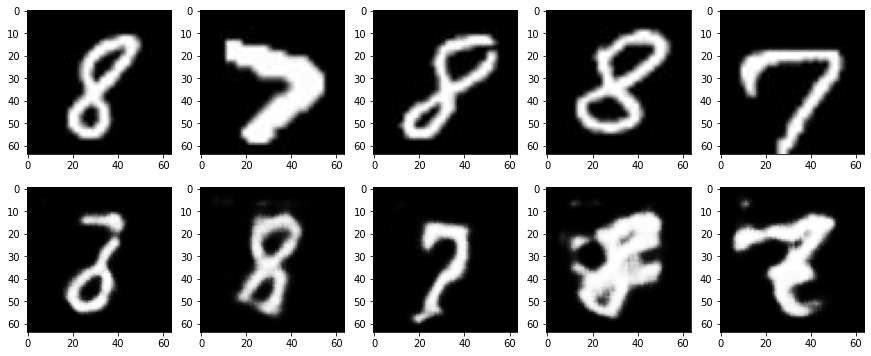

In [51]:
# 本セルは、良い感じの画像が生成されるまで、何度か実行をし直しています

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

In [52]:
!ls weights/

dcgan_d_100.pth  dcgan_g_160.pth  sagan_d_200.pth  sagan_g_180.pth
dcgan_d_120.pth  dcgan_g_180.pth  sagan_d_220.pth  sagan_g_20.pth
dcgan_d_140.pth  dcgan_g_20.pth   sagan_d_240.pth  sagan_g_200.pth
dcgan_d_160.pth  dcgan_g_200.pth  sagan_d_260.pth  sagan_g_220.pth
dcgan_d_180.pth  dcgan_g_40.pth   sagan_d_280.pth  sagan_g_240.pth
dcgan_d_20.pth	 dcgan_g_60.pth   sagan_d_300.pth  sagan_g_260.pth
dcgan_d_200.pth  dcgan_g_80.pth   sagan_d_40.pth   sagan_g_280.pth
dcgan_d_40.pth	 sagan_d_100.pth  sagan_d_60.pth   sagan_g_300.pth
dcgan_d_60.pth	 sagan_d_120.pth  sagan_d_80.pth   sagan_g_40.pth
dcgan_d_80.pth	 sagan_d_140.pth  sagan_g_100.pth  sagan_g_60.pth
dcgan_g_100.pth  sagan_d_160.pth  sagan_g_120.pth  sagan_g_80.pth
dcgan_g_120.pth  sagan_d_180.pth  sagan_g_140.pth
dcgan_g_140.pth  sagan_d_20.pth   sagan_g_160.pth


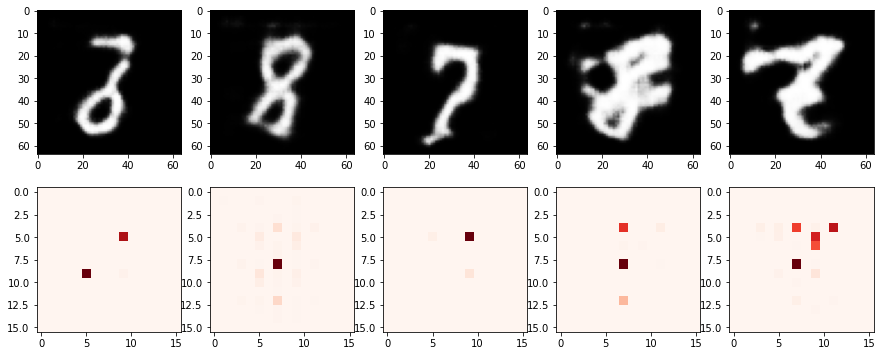

In [53]:
# Attentiom Mapを出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    # 上段に生成した画像データを
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # 下段にAttentin Map1の画像中央のピクセルのデータを
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 中央に着目
    plt.imshow(am.cpu().detach().numpy(), 'Reds')